<a href="https://colab.research.google.com/github/IGBK09/DS_artigo_pucrs/blob/main/DSartigo_igor_nascimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o Ambiente

In [2]:
#Importa bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Importando os Dados

In [3]:
#Carrega arquivo com histório do IPG-M
igpm = pd.read_excel("igpm_hist.xlsx", sheet_name='indice')
igpm['data'] = pd.to_datetime(igpm['data'])
igpm['data'] = igpm['data'].dt.strftime('%Y/%m')

igpm.head()

,data,igpm
0,2021/01,2.58
1,2021/02,2.53
2,2021/03,2.94
3,2021/04,1.51
4,2021/05,4.10


In [4]:
#Cria fator acumulado do IGP-M
deflator = [igpm['igpm'][0] + 100]

for i in range(1, len(igpm)):
    deflator1 = (1 + (igpm['igpm'][i] / 100)) * deflator[i-1]
    deflator.append(deflator1)

igpm['fator'] = deflator

igpm.tail()

,data,igpm,fator
31,2023/08,-0.14,117.664382
32,2023/09,0.37,118.099740
33,2023/10,0.50,118.690239
34,2023/11,0.59,119.390511
35,2023/12,0.74,120.274001


# Preparação dos dados

In [10]:
#Carrega base de dados de dados dos imóveis do DF
dados = pd.read_csv("imovel_df_2021_2023_vf.csv")
dados['DH_REFERENCIA_PROPOSTA'] = pd.to_datetime(dados['DH_REFERENCIA_PROPOSTA'])
dados['data'] = dados['DH_REFERENCIA_PROPOSTA'].dt.strftime('%Y/%m')

dados.head()

,Unnamed: 0,SG_UF,NU_PROPOSTA,QT_TOTAL_AREA,QT_AREA_PRIVATIVA,QT_AREA_TERRENO,NU_AREA_COMUM_IMOVEL,QT_DORMITORIO,QT_VAGA_GARAGEM_PRIVATIVA,SG_TIPO_LOGRADOURO,NO_BAIRRO,NU_CEP,NU_LOCALIDADE,DT_CRIACAO_PROPOSTA,NU_SEQUENCIAL_IMOVEL_INDIVIDUAL,VR_AVALIACAO,VR_COMPRA_VENDA,DH_REFERENCIA_PROPOSTA,data
0,0,DF,4.247600e+13,198.95,100.60,0.0,98.35,2.0,2.0,ST,ZONA INDUSTRIAL (GUARA),71218010.0,1809.0,2023-04-17,605320.0,1250000.0,1350000.00,2023-05-25 13:34:07,2023/05
1,1,DF,4.247600e+13,74.04,42.20,5138.3,31.84,1.0,1.0,R,AREAL (AGUAS CLARAS),71963000.0,1809.0,2023-03-09,1985179.0,312000.0,250000.00,2023-04-25 11:24:47,2023/04
2,2,DF,4.247600e+13,82.87,82.87,0.0,0.00,3.0,1.0,Q,TAGUATINGA SUL (TAGUATINGA),72015025.0,1809.0,2023-03-01,4702412.0,330000.0,327000.00,2023-03-09 14:50:30,2023/03
3,3,DF,4.247600e+13,43.35,31.22,1040.0,12.13,1.0,0.0,ST,ASA NORTE,70702909.0,1809.0,2022-12-06,4642751.0,203500.0,145569.44,2023-01-26 09:13:21,2023/01
4,4,DF,4.247600e+13,122.27,79.69,0.0,42.58,3.0,1.0,Q,GUARA II,71070640.0,1809.0,2021-12-29,4248960.0,719000.0,680000.00,2022-02-22 17:47:08,2022/02


In [11]:
#Observa o tamanho da base de dados
dados.shape

(14360, 19)

In [12]:
#Exclui possíveis dados duplicados e mantém o último
dados = dados.drop_duplicates(subset='NU_SEQUENCIAL_IMOVEL_INDIVIDUAL', keep="last")
dados.shape

(14084, 19)

In [13]:
#Mescla as tabelas de imóveis e IGP-M e calcula o valor do imóvel deflacionado
dados1 = pd.merge(dados, igpm, on='data')
dados1['valor_d'] = (dados1['VR_AVALIACAO'] * (dados1['fator']/100)).round(2)

dados1.head()

,Unnamed: 0,SG_UF,NU_PROPOSTA,QT_TOTAL_AREA,QT_AREA_PRIVATIVA,QT_AREA_TERRENO,NU_AREA_COMUM_IMOVEL,QT_DORMITORIO,QT_VAGA_GARAGEM_PRIVATIVA,SG_TIPO_LOGRADOURO,...,NU_LOCALIDADE,DT_CRIACAO_PROPOSTA,NU_SEQUENCIAL_IMOVEL_INDIVIDUAL,VR_AVALIACAO,VR_COMPRA_VENDA,DH_REFERENCIA_PROPOSTA,data,igpm,fator,valor_d
0,0,DF,4.247600e+13,198.95,100.60,0.0,98.35,2.0,2.0,ST,...,1809.0,2023-04-17,605320.0,1250000.0,1350000.0,2023-05-25 13:34:07,2023/05,-1.84,121.019544,1512744.30
1,71,DF,4.239210e+13,122.36,122.36,128.0,0.00,2.0,1.0,Q,...,1809.0,2023-05-03,4778736.0,292000.0,315000.0,2023-05-22 13:25:13,2023/05,-1.84,121.019544,353377.07
2,90,DF,4.236250e+13,200.00,200.00,200.0,0.00,3.0,2.0,Q,...,1809.0,2023-03-09,4314526.0,794000.0,300000.0,2023-05-15 11:07:05,2023/05,-1.84,121.019544,960895.18
3,216,DF,4.222200e+13,95.52,59.55,0.0,35.97,2.0,1.0,Q,...,1809.0,2023-04-13,4790083.0,320000.0,325000.0,2023-05-10 15:21:13,2023/05,-1.84,121.019544,387262.54
4,217,DF,4.222200e+13,115.86,68.29,0.0,47.57,2.0,1.0,Q,...,1809.0,2023-04-13,4772861.0,679000.0,700000.0,2023-05-11 15:41:46,2023/05,-1.84,121.019544,821722.70


In [14]:
#Separa os 3 primeiros dígitos do CEP
dados1['NU_CEP'] = dados1['NU_CEP'].astype(str)
dados1['cep'] = dados1['NU_CEP'].str[:3]

In [15]:
#Exclui variáveis que não serão utilizadas
dados2 = dados1.drop(columns=['NU_PROPOSTA', 'SG_TIPO_LOGRADOURO', 'QT_AREA_TERRENO', 'QT_TOTAL_AREA', 'NU_LOCALIDADE', 'DT_CRIACAO_PROPOSTA',
                            'NU_SEQUENCIAL_IMOVEL_INDIVIDUAL'])
dados2.head()

,Unnamed: 0,SG_UF,QT_AREA_PRIVATIVA,NU_AREA_COMUM_IMOVEL,QT_DORMITORIO,QT_VAGA_GARAGEM_PRIVATIVA,NO_BAIRRO,NU_CEP,VR_AVALIACAO,VR_COMPRA_VENDA,DH_REFERENCIA_PROPOSTA,data,igpm,fator,valor_d,cep
0,0,DF,100.60,98.35,2.0,2.0,ZONA INDUSTRIAL (GUARA),71218010.0,1250000.0,1350000.0,2023-05-25 13:34:07,2023/05,-1.84,121.019544,1512744.30,712
1,71,DF,122.36,0.00,2.0,1.0,SAMAMBAIA NORTE (SAMAMBAIA),72316219.0,292000.0,315000.0,2023-05-22 13:25:13,2023/05,-1.84,121.019544,353377.07,723
2,90,DF,200.00,0.00,3.0,2.0,GUARA II,71050171.0,794000.0,300000.0,2023-05-15 11:07:05,2023/05,-1.84,121.019544,960895.18,710
3,216,DF,59.55,35.97,2.0,1.0,TAGUATINGA NORTE (TAGUATINGA),72115510.0,320000.0,325000.0,2023-05-10 15:21:13,2023/05,-1.84,121.019544,387262.54,721
4,217,DF,68.29,47.57,2.0,1.0,AREA OCTOGONAL,70660086.0,679000.0,700000.0,2023-05-11 15:41:46,2023/05,-1.84,121.019544,821722.70,706


In [16]:
#Verifica tipo das variáveis e a existência de dados nulos
dados1.isnull().sum()

Unnamed: 0                         0
SG_UF                              0
NU_PROPOSTA                        0
QT_TOTAL_AREA                      0
QT_AREA_PRIVATIVA                  0
QT_AREA_TERRENO                    0
NU_AREA_COMUM_IMOVEL               0
QT_DORMITORIO                      0
QT_VAGA_GARAGEM_PRIVATIVA          0
SG_TIPO_LOGRADOURO                 0
NO_BAIRRO                          0
NU_CEP                             0
NU_LOCALIDADE                      0
DT_CRIACAO_PROPOSTA                0
NU_SEQUENCIAL_IMOVEL_INDIVIDUAL    0
VR_AVALIACAO                       0
VR_COMPRA_VENDA                    0
DH_REFERENCIA_PROPOSTA             0
data                               0
igpm                               0
fator                              0
valor_d                            0
cep                                0
dtype: int64

In [19]:
#Ordena as variáveis e renomeia
dados_ordem = ['data', 'cep', 'NO_BAIRRO', 'VR_AVALIACAO', 'valor_d', 'QT_AREA_PRIVATIVA', 'QT_DORMITORIO', 'QT_VAGA_GARAGEM_PRIVATIVA']
dados2 = dados1[dados_ordem]

In [20]:
#Cria array para localidade
dados2['cep'].unique()

array(['712', '723', '710', '721', '706', '719', '718', '702', '708',
       '707', '731', '725', '711', '724', '722', '733', '716', '717',
       '726', '720', '734', '730', '715', '703', '732', '729', '737',
       '700', '709', '714', '727', '728'], dtype=object)

In [21]:
#Cria grupo pelo cep e conta as quantidades e média do valor do imóvel e m² deflacionados por grupo
g = dados2.groupby(['cep'])
g_df = pd.DataFrame(g['data'].count())

In [22]:
dados3 = pd.merge(g_df.data, dados2, on='cep')

In [23]:
#Renomeia as variáveis após a integração
dados3 = dados3.rename(columns={'data_x':'qtd', 'data_y':'data', 'VR_AVALIACAO':'valor', 'NO_BAIRRO':'bairro', 'QT_AREA_PRIVATIVA':'area',
                       'QT_DORMITORIO':'quartos', 'QT_VAGA_GARAGEM_PRIVATIVA':'vagas'})

dados3.head()

,cep,qtd,data,bairro,valor,valor_d,area,quartos,vagas
0,700,17,2021/03,GUARA,1095000.0,1185528.33,116.64,3.0,2.0
1,700,17,2021/03,asa norte,700000.0,757871.99,69.75,2.0,0.0
2,700,17,2021/03,GUARA,780000.0,844485.93,147.90,3.0,2.0
3,700,17,2021/03,ASA SUL,180000.0,194881.37,28.35,0.0,0.0
4,700,17,2022/12,ASA NORTE,250000.0,310555.33,42.94,0.0,0.0


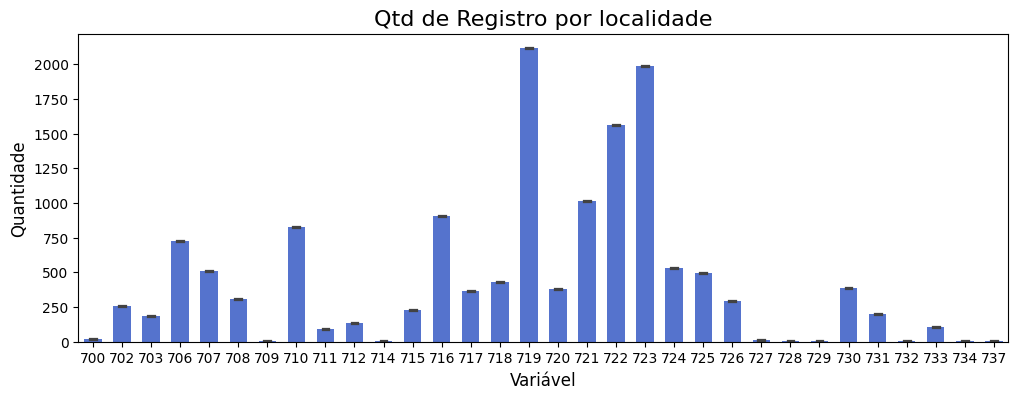

In [24]:
#Identifica CEP com pouca frequencia
plt.figure(figsize=(12 , 4))
ax = sns.barplot(dados3, x='cep', y='qtd', color='royalblue', capsize=0.2, width=0.6);
ax.set(xlabel = 'Localização', ylabel = 'Quantidade de registros');

plt.title('Qtd de Registro por localidade', fontsize=16)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Variável', fontsize=12)
plt.grid(False)
plt.show()

In [25]:
#Retira localidades com baixa frequência de dados
dados4 = dados3[dados3['qtd'] >=100]

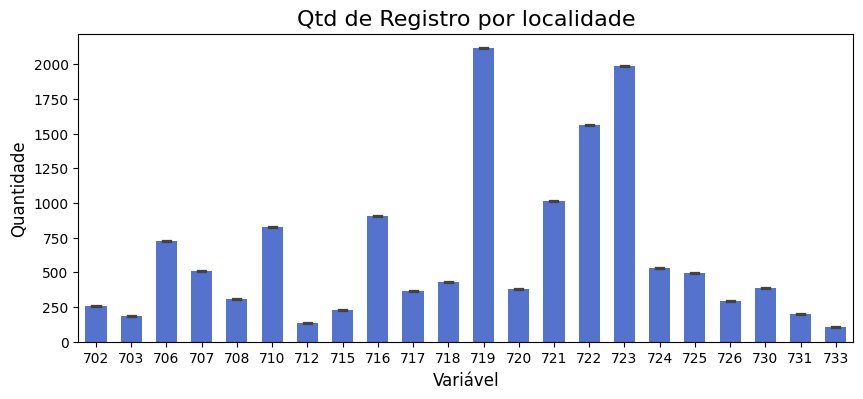

In [26]:
#Mostra resultado após retirar as localidades com baixa frequência
plt.figure(figsize=(10 , 4))
ax = sns.barplot(dados4, x='cep', y='qtd', color='royalblue', capsize=0.2, width=0.6);
ax.set(xlabel = 'Localização', ylabel = 'Quantidade de registros');

plt.title('Qtd de Registro por localidade', fontsize=16)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Variável', fontsize=12)
plt.grid(False)
plt.show()

In [27]:
# Função para filtrar o DataFrame para possíveis terrenos
def filtrar_dataframe(df):
    # Excluir as linhas com área superior a 1000
    df = df[(df['area'] <= 800) | (df['quartos'] != 0) | (df['vagas'] != 0)]

    return df

# Filtra possíveis terrenos
dados4 = filtrar_dataframe(dados4)
dados4

,cep,qtd,data,bairro,valor,valor_d,area,quartos,vagas
17,702,256,2023/05,ASA SUL,923000.0,1117010.39,103.74,3.0,0.0
18,702,256,2023/05,ASA SUL,759000.0,918538.34,86.30,3.0,0.0
19,702,256,2023/05,ASA SUL,570000.0,689811.40,63.07,3.0,0.0
20,702,256,2023/05,ASA SUL,717000.0,867710.13,80.73,3.0,0.0
21,702,256,2023/05,ASA SUL,860000.0,1040768.08,85.54,3.0,0.0
...,...,...,...,...,...,...,...,...,...
14074,733,104,2021/04,SETOR RESIDENCIAL LESTE (PLANALTINA),135000.0,148368.06,40.74,2.0,1.0
14075,733,104,2023/02,SETOR TRADICIONAL (PLANALTINA),618000.0,768843.36,200.00,3.0,1.0
14076,733,104,2023/02,JARDIM RORIZ (PLANALTINA),245000.0,304800.36,110.00,3.0,1.0
14077,733,104,2023/02,SETOR RESIDENCIAL LESTE (PLANALTINA),211000.0,262501.53,45.39,2.0,1.0


# Identificando outliers

In [28]:
#Exclui colunas para detecção de outliers
dados5 = dados4.drop(columns={'data', 'bairro', 'valor'})

dados5

,cep,qtd,valor_d,area,quartos,vagas
17,702,256,1117010.39,103.74,3.0,0.0
18,702,256,918538.34,86.30,3.0,0.0
19,702,256,689811.40,63.07,3.0,0.0
20,702,256,867710.13,80.73,3.0,0.0
21,702,256,1040768.08,85.54,3.0,0.0
...,...,...,...,...,...,...
14074,733,104,148368.06,40.74,2.0,1.0
14075,733,104,768843.36,200.00,3.0,1.0
14076,733,104,304800.36,110.00,3.0,1.0
14077,733,104,262501.53,45.39,2.0,1.0


In [29]:
dados5.describe()

,qtd,valor_d,area,quartos,vagas
count,13838.000000,1.383800e+04,13838.000000,13838.000000,13838.000000
mean,1131.159199,7.582960e+05,118.479433,2.404610,1.156598
std,702.194759,3.078392e+06,1094.807447,1.136222,1.043453
min,104.000000,6.374331e+04,1.000000,0.000000,0.000000
25%,497.000000,2.912410e+05,51.007500,2.000000,1.000000
50%,906.000000,4.088914e+05,74.035000,2.000000,1.000000
75%,1988.000000,7.235069e+05,123.087500,3.000000,2.000000
max,2114.000000,1.548180e+08,128049.750000,41.000000,48.000000


Tratamento dos dados - Erro de mensuração e amostragem

In [30]:
#Entende os outiliers superiores da variável 'area_total'
dados5['area'].nlargest(10)

11716    128049.75
4299       6578.00
13028      4485.00
4423       2125.00
4216       2040.00
4021       1321.81
3431       1300.00
3491       1271.50
3081       1200.00
4406       1099.32
Name: area, dtype: float64

In [31]:
#Observa os outiliers superiores da variável 'area_total'
dados5[dados5['area'] >= 1099]

,cep,qtd,valor_d,area,quartos,vagas
3081,715,228,2987591.99,1200.00,4.0,1.0
3431,716,906,8661394.16,1300.00,6.0,4.0
3491,716,906,6040464.92,1271.50,5.0,7.0
4021,716,906,11947221.97,1321.81,5.0,3.0
4216,717,366,3399977.13,2040.00,5.0,2.0
4299,717,366,347917.53,6578.00,3.0,0.0
4406,717,366,6079848.90,1099.32,3.0,3.0
4423,717,366,1611516.59,2125.00,4.0,2.0
11716,723,1988,148470.33,128049.75,1.0,0.0
13028,725,497,194357.66,4485.00,2.0,0.0


In [32]:
#Exclui outliers superiores da variável 'area'
out_area = [4299, 11716, 13028]
dados5 = dados5.drop(index=out_area)

In [33]:
#Entende os outiliers inferiores da variável 'area_total'
dados5['area'].nsmallest(10)

3327    1.0
3370    1.0
3435    1.0
3685    1.0
3689    1.0
3763    1.0
4214    1.0
4613    1.0
4774    1.0
5196    1.0
Name: area, dtype: float64

In [34]:
#Observa os outiliers inferiores da variável 'area_total'
dados5[dados5['area'] <= 20]

,cep,qtd,valor_d,area,quartos,vagas
414,703,183,208819.34,19.38,0.0,0.0
1652,707,507,1328699.64,1.25,3.0,0.0
1836,708,309,197160.90,14.99,0.0,0.0
1989,708,309,1701905.68,11.63,4.0,1.0
2057,710,824,342293.91,19.55,2.0,0.0
...,...,...,...,...,...,...
12638,725,497,454362.95,1.00,2.0,1.0
12680,725,497,268319.81,1.00,2.0,1.0
12985,725,497,369538.67,20.00,0.0,0.0
13750,730,390,637433.14,12.67,2.0,2.0


In [35]:
#Exclui outliers inferiores da variável 'area'
dados5[dados5['area'] >= 20]

,cep,qtd,valor_d,area,quartos,vagas
17,702,256,1117010.39,103.74,3.0,0.0
18,702,256,918538.34,86.30,3.0,0.0
19,702,256,689811.40,63.07,3.0,0.0
20,702,256,867710.13,80.73,3.0,0.0
21,702,256,1040768.08,85.54,3.0,0.0
...,...,...,...,...,...,...
14074,733,104,148368.06,40.74,2.0,1.0
14075,733,104,768843.36,200.00,3.0,1.0
14076,733,104,304800.36,110.00,3.0,1.0
14077,733,104,262501.53,45.39,2.0,1.0


In [36]:
#Entende os outiliers da variável 'quartos'
dados5['quartos'].nlargest(10)

5013     41.0
4919     21.0
10375    21.0
3074     15.0
12514    11.0
13232    10.0
4218      9.0
2250      8.0
2299      8.0
3267      8.0
Name: quartos, dtype: float64

In [37]:
#Observa os outiliers da variável 'quartos'
dados5[dados5['quartos'] >= 10]

,cep,qtd,valor_d,area,quartos,vagas
3074,715,228,2427175.02,221.18,15.0,0.0
4919,718,430,197187.16,60.00,21.0,0.0
5013,719,2114,1125481.76,121.80,41.0,2.0
10375,723,1988,305327.95,50.23,21.0,1.0
12514,724,530,659649.90,390.00,11.0,2.0
13232,726,297,1104651.93,372.00,10.0,0.0


In [38]:
#Exclui outliers dos quartos
dados5 = dados5[dados5['quartos'] <= 20]

In [39]:
#Entende os outiliers da variável 'vagas'
dados5['vagas'].nlargest(10)

12668    48.0
3465     42.0
9194     12.0
2300     11.0
3426     10.0
4459     10.0
3865      9.0
3477      8.0
3998      8.0
4245      8.0
Name: vagas, dtype: float64

In [40]:
#Observa os outiliers da variável 'vagas'
dados5[dados5['vagas'] >= 8]

,cep,qtd,valor_d,area,quartos,vagas
2300,710,824,409459.34,48.02,3.0,11.0
3426,716,906,2349403.17,156.02,4.0,10.0
3465,716,906,2731040.89,437.22,5.0,42.0
3477,716,906,1806649.31,250.00,3.0,8.0
3865,716,906,1577629.11,489.30,7.0,9.0
3998,716,906,4370395.46,536.82,3.0,8.0
4245,717,366,4816092.10,608.00,5.0,8.0
4459,717,366,2858504.76,562.59,4.0,10.0
4501,717,366,3073799.83,598.30,4.0,8.0
9194,722,1559,357903.55,80.54,3.0,12.0


In [41]:
#Exclui outliers das vagas
dados5 = dados5[dados5['vagas'] <= 10]

Tratamento dos dados - Outliers naturais dos dados da variável target

In [42]:
#Cria função para remover os outliers da variável 'valor deflacionado'
def remove_outlier(dataframe, group_var, value_var, threshold=1.5):
    dataframe_nout = pd.DataFrame()

    for group_value in dataframe[group_var].unique():
        group_data = dataframe[dataframe[group_var] == group_value]

        Q1 = group_data[value_var].quantile(0.25)
        Q3 = group_data[value_var].quantile(0.75)
        IQR = Q3 - Q1

        l_inf = Q1 - threshold * IQR
        l_sup = Q3 + threshold * IQR

        group_data_nout = group_data[(group_data[value_var] >= l_inf) & (group_data[value_var] <= l_sup)]

        dataframe_nout = pd.concat([dataframe_nout, group_data_nout])

    return dataframe_nout

#Remove os outliers da variável 'valor deflacionado'
dados6 = remove_outlier(dados5, 'cep', 'valor_d')
dados6

,cep,qtd,valor_d,area,quartos,vagas
17,702,256,1117010.39,103.74,3.0,0.0
18,702,256,918538.34,86.30,3.0,0.0
19,702,256,689811.40,63.07,3.0,0.0
20,702,256,867710.13,80.73,3.0,0.0
21,702,256,1040768.08,85.54,3.0,0.0
...,...,...,...,...,...,...
14074,733,104,148368.06,40.74,2.0,1.0
14075,733,104,768843.36,200.00,3.0,1.0
14076,733,104,304800.36,110.00,3.0,1.0
14077,733,104,262501.53,45.39,2.0,1.0


Entendimento dos dados

In [43]:
dados6.describe()

,qtd,valor_d,area,quartos,vagas
count,13180.000000,1.318000e+04,13180.000000,13180.000000,13180.000000
mean,1133.635432,5.836443e+05,101.381750,2.350152,1.106525
std,704.376381,5.125940e+05,95.059242,1.027620,0.847882
min,104.000000,6.374331e+04,1.000000,0.000000,0.000000
25%,497.000000,2.860422e+05,50.100000,2.000000,1.000000
50%,906.000000,3.945227e+05,70.880000,2.000000,1.000000
75%,1988.000000,6.707881e+05,117.442500,3.000000,1.000000
max,2114.000000,5.222090e+06,2125.000000,15.000000,10.000000


(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'cep'),
  Text(2, 0, 'qtd'),
  Text(3, 0, 'valor_d'),
  Text(4, 0, 'area'),
  Text(5, 0, 'quartos'),
  Text(6, 0, 'vagas')])

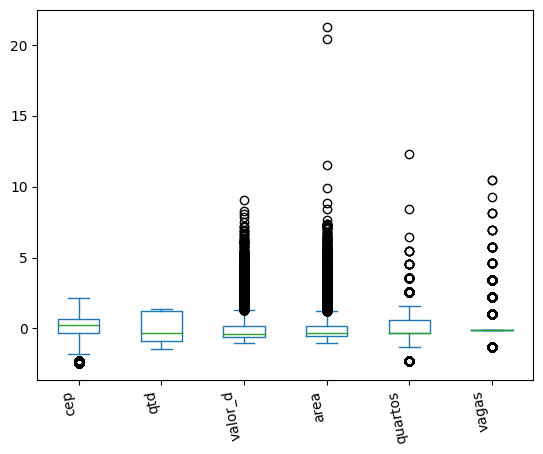

In [44]:
dados6.apply(scale).plot.box()
plt.xticks(rotation=100
           , ha='right')

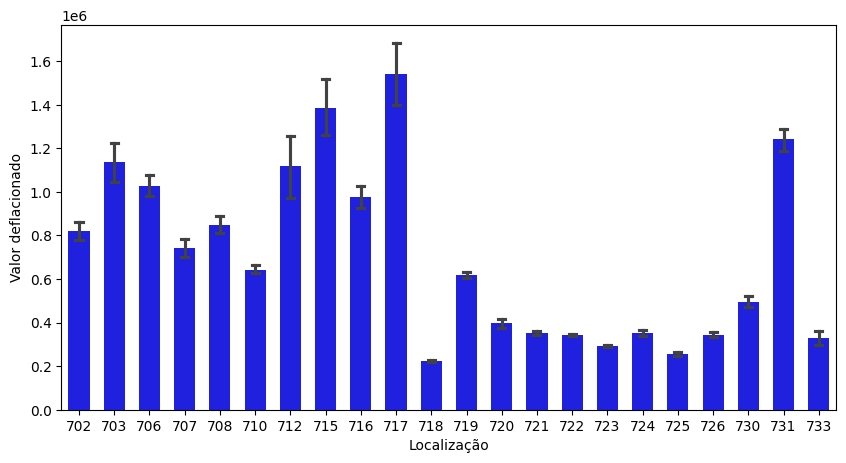

In [45]:
#Plota gráfico de barra para verificar distribuição de valores dos imóveis por cep
plt.figure(figsize=(10 , 5))
ax = sns.barplot(dados6, y='valor_d', x='cep', color='blue', capsize=0.2, width=0.6);
ax.set(xlabel = 'Localização', ylabel = 'Valor deflacionado');

<ipython-input-46-5c901051b2fa>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dados6.corr(), annot=True, cmap='YlGnBu')


<Axes: >

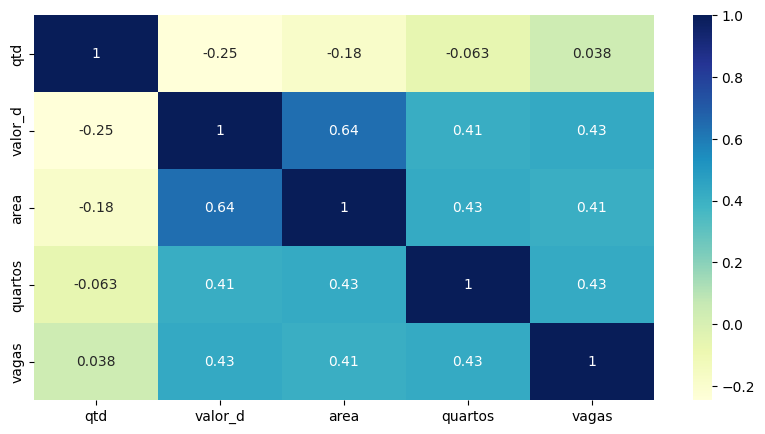

In [46]:
#Plota mapa de correlação entre variáveis
plt.figure(figsize=(10 , 5))
sns.heatmap(dados6.corr(), annot=True, cmap='YlGnBu')

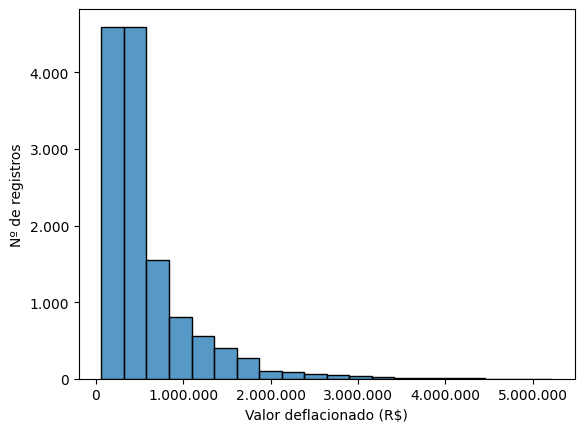

In [47]:
#Cria função para formatar a divisão de milhares para o padrão brasileiro
def format_thousands(x, pos):
    return '{:,.0f}'.format(x).replace(',', '.')

#Plota histograma da variável valor deflacionado
sns.histplot(dados6['valor_d'], bins=20)
plt.xlabel("Valor deflacionado (R$)")
plt.ylabel("Nº de registros")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.show()

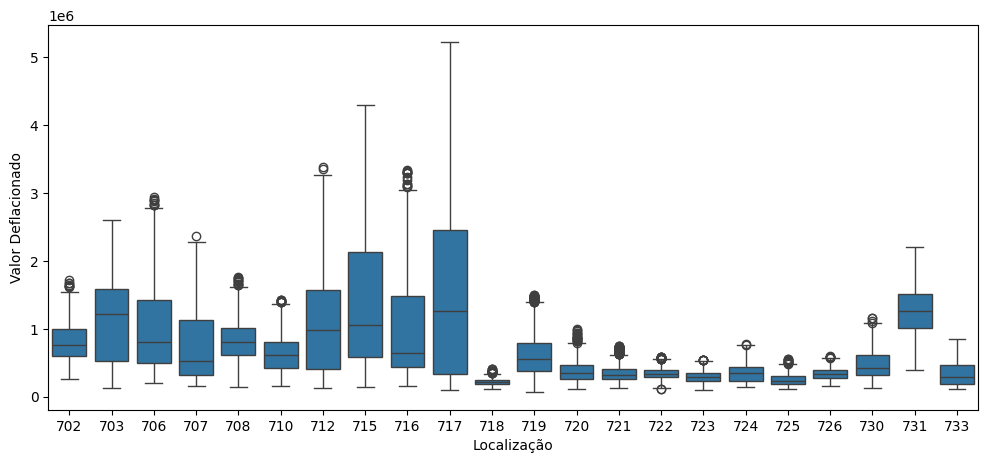

In [48]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='cep', y='valor_d', data=dados6)
plt.xlabel('Localização')
plt.ylabel('Valor Deflacionado')
plt.show()

# Executando os modelos

Definindo dados de treinamento e de teste

In [49]:
# Codificar a variável categórica usando one-hot encoding
dados7 = pd.get_dummies(dados6, columns=['cep'])
dados7.columns

Index(['qtd', 'valor_d', 'area', 'quartos', 'vagas', 'cep_702', 'cep_703',
       'cep_706', 'cep_707', 'cep_708', 'cep_710', 'cep_712', 'cep_715',
       'cep_716', 'cep_717', 'cep_718', 'cep_719', 'cep_720', 'cep_721',
       'cep_722', 'cep_723', 'cep_724', 'cep_725', 'cep_726', 'cep_730',
       'cep_731', 'cep_733'],
      dtype='object')

In [50]:
#Define variáveis independentes (X) e dependente(Y)
X = dados7[['area', 'quartos', 'vagas', 'cep_702', 'cep_703',
       'cep_706', 'cep_707', 'cep_708', 'cep_710', 'cep_712', 'cep_715',
       'cep_716', 'cep_717', 'cep_718', 'cep_719', 'cep_720', 'cep_721',
       'cep_722', 'cep_723', 'cep_724', 'cep_725', 'cep_726', 'cep_730',
       'cep_731', 'cep_733']]
Y = dados7[['valor_d']]

In [51]:
#Normalização dos dados
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X)
X_test_scaler = scaler.transform(X)

In [52]:
#Divide os dados em conjunto de treino e de teste com seed
seed = 42
X_train_scaler, X_test_scaler, y_train, y_test = train_test_split(X, Y, train_size = 0.7,
                                                      test_size = 0.3, random_state = seed)

print(X_train_scaler.shape)
print(X_test_scaler.shape)
print(y_train.shape)
print(y_test.shape)

(9226, 25)
(3954, 25)
(9226, 1)
(3954, 1)


# Modelo de Regressão Linear Múltipla

In [53]:
#Cria modelo de Regressão Linear Múltipla
model_rlm = LinearRegression()
model_rlm.fit(X_train_scaler, y_train)
y_pred_rlm = model_rlm.predict(X_test_scaler)

In [54]:
#Printa as métricas de desempenho
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rlm))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred_rlm, squared=False))
print('R2:', metrics.r2_score(y_test, y_pred_rlm))

MSE: 78753918143.95102
RMSE: 280631.28504133504
R2: 0.7115219034851615


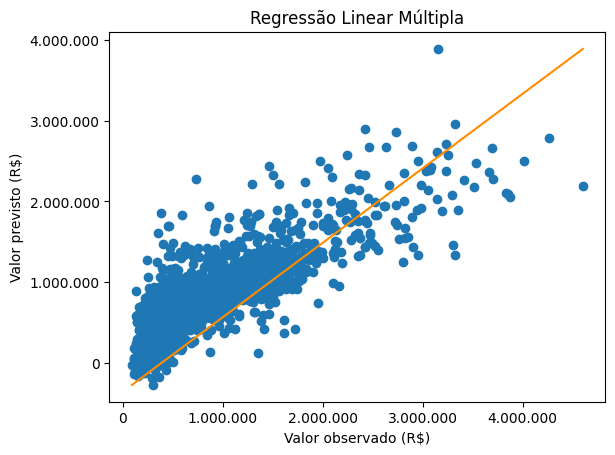

In [55]:
#Plota gráfico para visualização dos resultados
plt.scatter(y_test, y_pred_rlm)
plt.plot([y_test.min(), y_test.max()], [y_pred_rlm.min(), y_pred_rlm.max()], color='darkorange')
plt.xlabel('Valor observado (R$)')
plt.ylabel('Valor previsto (R$)')
plt.title('Regressão Linear Múltipla')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.show()

# Modelo XGBoost

In [56]:
#Cria modelo de modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=seed, enable_categorical=True)
model_xgb.fit(X_train_scaler, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaler)

In [57]:
#Printa as métricas de desempenho
print('MSE:', metrics.mean_squared_error(y_test, y_pred_xgb))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred_xgb, squared=False))
print('R2:', metrics.r2_score(y_test, y_pred_xgb))

MSE: 37986553563.615555
RMSE: 194901.39446298365
R2: 0.8608540511576761


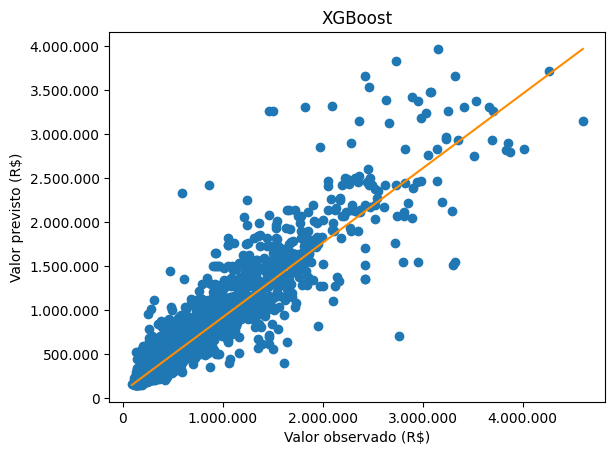

In [58]:
#Plota gráfico para visualização dos resultados
plt.scatter(y_test, y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_pred_xgb.min(), y_pred_xgb.max()], color='darkorange')
plt.xlabel('Valor observado (R$)')
plt.ylabel('Valor previsto (R$)')
plt.title('XGBoost')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.show()

# Modelo de Rede Neural Artificial (MLP)

In [60]:
#Cria modelo de modelo de Rede Neural Artificial
model_rna = Sequential([
    Dense(64, activation='ReLU', input_shape=(X_train_scaler.shape[1],)),
    Dense(64, activation='ReLU'),
    Dense(64, activation='ReLU'),
    Dense(1)
])

#Compila modelo
model_rna.compile(optimizer='adam', loss='mean_squared_error')

In [61]:
# Converte os dados de entrada em tensores do TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train_scaler, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_scaler, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

# Treina o modelo
model_rna.fit(X_train_tensor, y_train_tensor, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
260/260 [==============================] - 3s 5ms/step - loss: 546770223104.0000 - val_loss: 424752185344.0000
Epoch 2/100
260/260 [==============================] - 1s 4ms/step - loss: 208540516352.0000 - val_loss: 186329481216.0000
Epoch 3/100
260/260 [==============================] - 1s 4ms/step - loss: 175604793344.0000 - val_loss: 185115443200.0000
Epoch 4/100
260/260 [==============================] - 1s 3ms/step - loss: 173348159488.0000 - val_loss: 185195380736.0000
Epoch 5/100
260/260 [==============================] - 1s 2ms/step - loss: 170432905216.0000 - val_loss: 184903401472.0000
Epoch 6/100
260/260 [==============================] - 1s 2ms/step - loss: 168552415232.0000 - val_loss: 179607977984.0000
Epoch 7/100
260/260 [==============================] - 1s 2ms/step - loss: 165531123712.0000 - val_loss: 175711404032.0000
Epoch 8/100
260/260 [==============================] - 1s 3ms/step - loss: 162878062592.0000 - val_loss: 174490255360.0000
Epoch 9/100
260/

In [62]:
#Avalia o modelo
y_pred_rna = model_rna.predict(X_test_tensor)

#Printa as métricas de desempenho
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rna))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred_rna, squared=False))
print('R2:', metrics.r2_score(y_test, y_pred_rna))

124/124 [==============================] - 0s 1ms/step
MSE: 67524874973.01323
RMSE: 259855.48863361194
R2: 0.7526542442750386


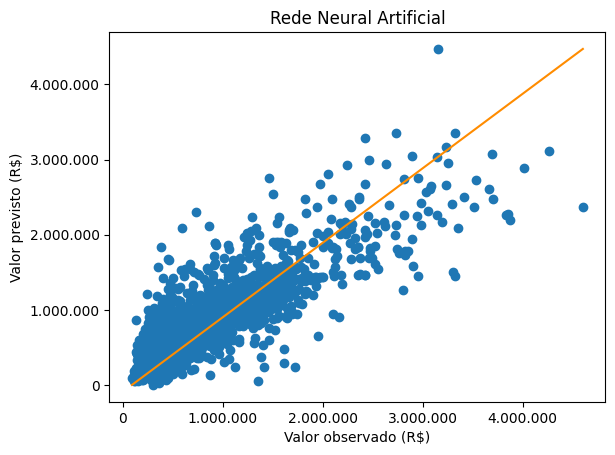

In [63]:
#Plota gráfico para visualização dos resultados
plt.scatter(y_test_tensor, y_pred_rna)
plt.plot([y_test.min(), y_test.max()], [y_pred_rna.min(), y_pred_rna.max()], color='darkorange')
plt.xlabel('Valor observado (R$)')
plt.ylabel('Valor previsto (R$)')
plt.title('Rede Neural Artificial')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
plt.show()